# Problem Set 3
Designed by Sarah Adel Bargal, Ben Usman, and Kun He, with help from Kate Saenko and Brian Kulis.

This assignment will introduce you to:
- building, training, and testing of neural networks in TensorFlow
- using TensorFlow on the SCC cluster
- extracting and visualizing neural network features

Note: For programming, the use of any additional abstraction of TensorFlow (like `Keras` and `tf.contrib.learn`) is **not permitted**.

## Part 0: Tutorials
The contents of these tutorials are helpful for solving this assignment and upcoming assignments. Please be sure to go through them before proceeding.
1. [MNIST For ML Beginners](https://www.tensorflow.org/versions/r0.10/tutorials/mnist/beginners/)
2. [Deep MNIST for Experts](https://www.tensorflow.org/versions/r0.10/tutorials/mnist/pros/)
3. [TensorFlow Mechanics 101](https://www.tensorflow.org/versions/r0.10/tutorials/mnist/tf/)
4. [Sharing Variables](https://www.tensorflow.org/programmers_guide/variable_scope)

## Part 1: MNIST Softmax Classifier Demo in TensorFlow

TensorFlow is already installed on the SCC. Please review the instructions on [connecting to SCC](https://docs.google.com/document/d/1C4XrrTZIRfmJ6-LHmuJ4levTnunezujVrxCz8jJ4rec), and [running jobs on SCC](http://www.bu.edu/tech/support/research/system-usage/running-jobs/).

Make sure you are capable of running this demo (using `qsub`) on the SCC cluster: [`mnist_softmax_scope.py`](https://github.com/kunhe/cs591s2/blob/master/mnist_softmax_scope.py). There is no required deliverable, but this exercise is helpful for running jobs on the SCC in the future.

The demo is another implementation of `mnist_softmax.py` presented in the MNIST for ML Beginners tutorial, but using scopes. For the purposes of this assignment, the contents of the demo is also replicated below.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

def logistic_regression(x_):
    # create the actual model
    scope_args = {'initializer': tf.random_normal_initializer(stddev=1e-4)}
    with tf.variable_scope("weights", **scope_args):
        W = tf.get_variable('W', shape=[784, 10])
        b = tf.get_variable('b', shape=[10])
        y_logits = tf.matmul(x_, W) + b
    return y_logits

def test_classification(model_function, learning_rate=0.1):
    # import data
    mnist = input_data.read_data_sets('./datasets/mnist/', one_hot=True)

    with tf.Graph().as_default() as g:
        # where are you going to allocate memory and perform computations
        with tf.device("/cpu:0"):
            
            # define model "input placeholders", i.e. variables that are
            # going to be substituted with input data on train/test time
            x_ = tf.placeholder(tf.float32, [None, 784])
            y_ = tf.placeholder(tf.float32, [None, 10])
            y_logits = model_function(x_)
            
            
            # naive implementation of loss:
            # > losses = y_ * tf.log(tf.nn.softmax(y_logits))
            # > tf.reduce_mean(-tf.reduce_sum(losses, 1))
            # can be numerically unstable.
            #
            # so here we use tf.nn.softmax_cross_entropy_with_logits on the raw
            # outputs of 'y', and then average across the batch.
            
            losses = tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_logits)
            cross_entropy_loss = tf.reduce_mean(losses)
            train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy_loss)
            
            y_pred = tf.argmax(tf.nn.softmax(y_logits), dimension=1)
            correct_prediction = tf.equal(y_pred, tf.argmax(y_, 1))
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    with g.as_default(), tf.Session() as sess:
        # that is how we "execute" statements 
        # (return None, e.g. init() or train_op())
        # or compute parts of graph defined above (loss, output, etc.)
        # given certain input (x_, y_)
        sess.run(tf.initialize_all_variables())
        
        # train
        for iter_i in range(20001):
            batch_xs, batch_ys = mnist.train.next_batch(100)
            sess.run(train_step, feed_dict={x_: batch_xs, y_: batch_ys})
            
            # test trained model
            if iter_i % 2000 == 0:
                tf_feed_dict = {x_: mnist.test.images, y_: mnist.test.labels}
                acc_value = sess.run(accuracy, feed_dict=tf_feed_dict)
                print('iteration %d\t accuracy: %.3f'%(iter_i, acc_value))
                
test_classification(logistic_regression, learning_rate=0.1)


Extracting ./datasets/mnist/train-images-idx3-ubyte.gz
Extracting ./datasets/mnist/train-labels-idx1-ubyte.gz
Extracting ./datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting ./datasets/mnist/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Use `tf.global_variables_initializer` instead.
iteration 0	 accuracy: 0.406
iteration 2000	 accuracy: 0.916
iteration 4000	 accuracy: 0.921
iteration 6000	 accuracy: 0.923
iteration 8000	 accuracy: 0.923
iteration 10000	 accuracy: 0.923
iteration 12000	 accuracy: 0.923
iteration 14000	 accuracy: 0.924
iteration 16000	 accuracy: 0.923
iteration 18000	 accuracy: 0.923
iteration 20000	 accuracy: 0.924


## Part 2: Building Neural Networks in TensorFlow

(45 points)

### Q2.1 MLP in TensorFlow

Task: 

- Implement a multi-layer perceptron function **`mlp(x, hidden_sizes, activation_fn)`** in TensorFlow that has the following input and output: 

 **Inputs**
 - `x`, an input tensor of the images in the current batch `[batch_size, 28x28]`
 - `hidden_sizes`, a list of the number of hidden units per layer. For example: `[5,2]` means  5 hidden units in the first layer, and 2 hidden units in the second (output) layer.
 (Note: for MNIST, we need `hidden_sizes[-1]==10` since it has 10 classes.)
 - `activation_fn`, the activation function to be applied

 **Output**
 - a tensor of shape `[batch_size, hidden_sizes[-1]]`. 

**Note: ** 
- Make sure the activation function is not applied to the final (output) layer.
- It is recommended to use scopes and `tf.get_variable()` (as opposed to `tf.Variable()` which you may see elsewhere), as demonstrated in the sample code, and explained in the "Sharing Variables" tutorial in Part 0. Also see [here](http://stackoverflow.com/questions/37098546/difference-between-variable-and-get-variable-in-tensorflow).

In [2]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data


def mlp_1(x, hidden_sizes, activation_fn=tf.nn.relu):
    
    input_size = 784
    hidden_nodes = [input_size] + hidden_sizes 
    print(hidden_nodes[0])
    print(hidden_nodes[1])
    
    hidden_list = []
    hidden_list.append(x)
    
    if not isinstance(hidden_sizes, (list, tuple)):
        raise ValueError("hidden_sizes must be a list or a tuple")
    else: 
        
        for i in range(len(hidden_nodes)-2):
            with tf.variable_scope("hidden" + str(i)):
                W = tf.get_variable('W', shape=[hidden_nodes[i], hidden_nodes[i+1]], initializer = tf.random_uniform_initializer(minval=-0.2, maxval=.2))
                #  W = tf.get_variable('W', shape=[hidden_nodes[i], hidden_nodes[i+1]], initializer = tf.random_uniform_initializer())
                b = tf.get_variable('b', shape=[hidden_nodes[i+1]], initializer=tf.random_normal_initializer(mean = 0.1, stddev=2e-4))
                hidden = tf.nn.relu(tf.matmul(hidden_list[i], W) + b)
                hidden_list.append(hidden)
            
        with tf.variable_scope('softmax'):
            W = tf.get_variable('W', shape=[hidden_nodes[-2], hidden_nodes[-1]], initializer=tf.random_uniform_initializer(minval=-0.2, maxval=.2))
            #W = tf.get_variable('W', shape=[hidden_nodes[-2], hidden_nodes[-1]], initializer=tf.random_uniform_initializer())
            b = tf.get_variable('b', shape=[hidden_nodes[-1]], initializer=tf.random_normal_initializer(mean = 0.1, stddev=2e-4))
            a = hidden_list[-1]
            print(a.shape)
            logits = tf.matmul(hidden_list[-1], W) + b
                  
    return logits


# def mlp(x, hidden_sizes, activation_fn=tf.nn.relu):
    
#     if not isinstance(hidden_sizes, (list, tuple)):
#         raise ValueError("hidden_sizes must be a list or a tuple")
#     else: 
#         #scope_args = {'initializer': tf.random_normal_initializer(stddev=1e-4)}
#         with tf.variable_scope("hidden1"):
#             W = tf.get_variable('W', shape=[784, hidden_sizes[0]], initializer = tf.random_normal_initializer())
#             b = tf.get_variable('b', shape=[hidden_sizes[0]], initializer=tf.random_normal_initializer(mean = 0.05))
#             hidden1 = tf.nn.relu(tf.matmul(x, W) + b)
#         with tf.variable_scope('hidden2'):
#             W = tf.get_variable('W', shape=[hidden_sizes[0], hidden_sizes[1]], initializer=tf.random_normal_initializer() )
#             b = tf.get_variable('b', shape=[hidden_sizes[1]], initializer=tf.random_normal_initializer(mean = 0.05))
#             hidden2 = tf.nn.relu(tf.matmul(hidden1, W) + b)
#         with tf.variable_scope('softmax'):
#             W = tf.get_variable('W', shape=[hidden_sizes[1], hidden_sizes[2]], initializer=tf.random_normal_initializer() )
#             b = tf.get_variable('b', shape=[hidden_sizes[2]], initializer=tf.random_normal_initializer(mean = 0.05))
#             logits = tf.matmul(hidden2, W) + b
             
#     return logits
#     ###################################
#     ####     PUT YOUR CODE HERE    ####
#     ###################################


The following code tests your  implementation of the **`mlp()`** function. It basically recreates the 2-layer MLP with ReLU activation that you implemented in Problem Set 2. It should give an accuracy of above 0.97.

In [3]:

test_classification(lambda x: mlp_1(x, [64,10], activation_fn=tf.nn.relu), learning_rate=0.1)

Extracting ./datasets/mnist/train-images-idx3-ubyte.gz
Extracting ./datasets/mnist/train-labels-idx1-ubyte.gz
Extracting ./datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting ./datasets/mnist/t10k-labels-idx1-ubyte.gz
784
64
(?, 64)
Instructions for updating:
Use `tf.global_variables_initializer` instead.
iteration 0	 accuracy: 0.169
iteration 2000	 accuracy: 0.942
iteration 4000	 accuracy: 0.957
iteration 6000	 accuracy: 0.963
iteration 8000	 accuracy: 0.966
iteration 10000	 accuracy: 0.969
iteration 12000	 accuracy: 0.971
iteration 14000	 accuracy: 0.972
iteration 16000	 accuracy: 0.974
iteration 18000	 accuracy: 0.973
iteration 20000	 accuracy: 0.973


### Q2.2 Siamese Network
A siamese network is a network having two identical subnetworks that share parameters. A siamese network gives a *similarity metric* between pairs of inputs, which assigns high values to similar pairs and low values to dissimilar pairs. In MNIST, we can construct similar pairs by taking images from the same digit class, and dissimilar pairs from images from different classes. 


A sample Siamese network is presented below [Koch et al., Siamese Neural Networks for One-shot Image Recognition, ICML 2015]. Note how the two subnetworks have identical parameters:

<img src="siamese.png" style="width:480px;">


Given a Siamese network, we can determine the similarity between inputs $x_1$ and $x_2$, by taking the sign of the cosine similarity $\frac{\langle r_1,r_2\rangle}{\|r_1\|\|r_2\|}$, where $r_1$ and $r_2$ are the hidden representations produced by the network for $x_1$ and $x_2$, respectively. 

Tasks:

1. Build a Siamese Network in TensorFlow that receives as input two MNIST images, and decides whether they belong to the same digit category. Each subnetwork is an MLP with 2 hidden layers with 64 units, followed by a "distance layer" with 32 units. They will be created using the **`mlp()`** function you implemented earlier, using input argument `hidden_sizes=[64,64,32]`. The network computes the cosine similarity, as defined above, in the final output layer.

2. Train and test this model, and  report your test accuracy for this task.

You will need to implement the following two functions.

In [4]:
#################################################################
# Inputs: arr1 and arr2 have shape [batch_size, hidden_sizes[-1]]
# Output: return tensor of shape [batch_size, ], the cosine 
#         similarity betwwen arr1 and arr2
# 
# Hint: use tf.l2_normalize, tf.mul, tf.reduce_sum
#################################################################
def cosine_similarity(arr1, arr2):
    
    #arr1_norm = tf.nn.l2_normalize(arr1, dim=1)
    #arr2_norm = tf.nn.l2_normalize(arr2, dim=1)
    #test = tf.multiply(tf.nn.l2_normalize(arr1, 0), tf.nn.l2_normalize(arr2, 0))
    
    #cos_sim = tf.reduce_sum(tf.matmul(arr1_norm, tf.transpose(arr2_norm, [1, 0])), 0)
    
    cos_sim = tf.reduce_sum(tf.multiply(tf.nn.l2_normalize(arr1, dim = 1), tf.nn.l2_normalize(arr2, dim = 1)), 1)
    
    ###################################
    ####     PUT YOUR CODE HERE    ####
    ###################################
    
    return cos_sim

#################################################################
# Inputs: mlp_args is a dictionary of arguments to the mlp() 
#         function. 
#         Example: mlp_args = {'hidden_sizes':[64, 64, 32]}
################################################################
def build_model(mlp_args):
    with tf.Graph().as_default() as g:
        with tf.device("/cpu:0"):
            x1 = tf.placeholder(tf.float32, [None, 784])
            x2 = tf.placeholder(tf.float32, [None, 784])
            y = tf.placeholder(tf.float32, [None])
            print('y:', y.shape)
            with tf.variable_scope("siamese") as var_scope:
                x_repr1 = mlp_1(x1, **mlp_args)  # hidden representation of x1
                var_scope.reuse_variables()    # weight sharing! 
                x_repr2 = mlp_1(x2, **mlp_args)  # hidden representation of x2
                logits = cosine_similarity(x_repr1, x_repr2)  # similarity
                print('x_repr1', x_repr1.shape)
                print('logits:', logits.shape)
                
                
            ###################################
            ####     PUT YOUR CODE HERE    ####
            ###################################
            
            # define scalar: loss 
            loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = y, logits = logits))
            
            # define vector: y_prob as sigmoid(cosine_similarity)
            #y_prob = tf.argmax(tf.nn.sigmoid(logits),1)
            y_prob = tf.nn.sigmoid(logits)
           
            # define vector: y_pred as sign(cosine_similarity)
            y_pred_bool = logits >= 0
            #y_pred = y_pred_bool
            
            y_pred = tf.cast(y_pred_bool, tf.float32)
            
            correct_prediction = tf.equal(y_pred, y)
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
            # define scalar: accuracy as the fraction of correct predictions
            
    return {'graph': g, 'inputs': [x1, x2, y], 'pred': y_pred, 'logits': logits,
            'prob': y_prob, 'loss': loss, 'accuracy': accuracy, 'y_pred_bool': y_pred_bool}

The following code segment prepares minibatch training data.

In [5]:
# data preparation
import numpy as np
def mnist_siamese_dataset_iterator(batch_size, dataset_name):
    assert dataset_name in ['train', 'test']
    assert batch_size > 0 or batch_size == -1 # -1 for entire dataset
    mnist = input_data.read_data_sets('./datasets/mnist/', one_hot=True)
    dataset = getattr(mnist, dataset_name)
    
    while True:
        if batch_size > 0:
            X1, y1 = dataset.next_batch(batch_size)
            X2, y2 = dataset.next_batch(batch_size)
            y = np.argmax(y1, axis=1) == np.argmax(y2, axis=1)
            yield X1, X2, y, y1
        else:
            X1 = dataset.images
            idx = np.arange(len(X1))
            np.random.shuffle(idx)
            X2 = X1[idx]
            y1 = dataset.labels
            y2 = y1[idx]
            y = np.argmax(y1, axis=1) == np.argmax(y2, axis=1)
            yield X1, X2, y, y1

Now let's run the training.

Note: if you have a good GPU, you could change `tf.device("/cpu:0")` to `tf.device("/gpu:0")` in your **`build_model()`** function to speed up training.

In [9]:
try:
    from itertools import izip as zip
except ImportError:
    print('This is Python 3')

def run_training(model_dict, train_data_iterator, test_full_iter, 
                 train_full_iter, n_iter=10000, print_every=100):
    with model_dict['graph'].as_default():
        optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.4)
        train_op = optimizer.minimize(model_dict['loss'])
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            for iter_i, data_batch in zip(range(n_iter), train_data_iterator):
                batch_feed_dict = dict(zip(model_dict['inputs'], data_batch))
                sess.run(train_op, feed_dict=batch_feed_dict)
                if iter_i % print_every == 0:
                    print_zip_iter = zip([test_full_iter, train_full_iter], ['test', 'train'])
                    for data_iterator, data_name in print_zip_iter:
                        test_batch = next(data_iterator)
                        batch_feed_dict = dict(zip(model_dict['inputs'], test_batch))
                        to_compute = [model_dict['accuracy'], model_dict['loss']]
                        acc_value, loss_val = sess.run(to_compute, batch_feed_dict)
                        fmt = (iter_i, acc_value, loss_val)
                        print(data_name, 'iteration %d\t accuracy: %.3f, loss: %.3f'%fmt)
                        

def run_training_test(model_dict, train_data_iterator, test_full_iter, 
                 train_full_iter, n_iter=1000, print_every=100):
    with model_dict['graph'].as_default():
        optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.1)
        train_op = optimizer.minimize(model_dict['loss'])
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            for iter_i, data_batch in zip(range(n_iter), train_data_iterator):
                
                batch_feed_dict = dict(zip(model_dict['inputs'], data_batch))
                sess.run(train_op, feed_dict=batch_feed_dict)
                if iter_i % print_every == 0:
                    print_zip_iter = zip([test_full_iter, train_full_iter], ['test', 'train'])
                    for data_iterator, data_name in print_zip_iter:
                        test_batch = next(data_iterator)
                        batch_feed_dict = dict(zip(model_dict['inputs'], test_batch))
                        to_compute = [model_dict['accuracy'], model_dict['y_pred_bool'], model_dict['inputs'], model_dict['logits']]
                        acc_value, pred_val, input_val, logits_val = sess.run(to_compute, batch_feed_dict)
                        print('pred:', pred_val)
                        print('y:',input_val[2])
                        print('logit:', logits_val)
                        fmt = (iter_i, acc_value)
                        print(data_name, 'iteration %d\t accuracy: %.3f'%fmt)
                        
                        
                        
train_data_iterator = mnist_siamese_dataset_iterator(700, 'train')
test_full_iter = mnist_siamese_dataset_iterator(-1, 'test')
train_full_iter = mnist_siamese_dataset_iterator(-1, 'train')

mlp_args = {'hidden_sizes':[64, 64, 32]}
model = build_model(mlp_args)
run_training(model, train_data_iterator, test_full_iter, train_full_iter)

y: (?,)
784
64
(?, 64)
784
64
(?, 64)
x_repr1 (?, 32)
logits: (?,)
Extracting ./datasets/mnist/train-images-idx3-ubyte.gz
Extracting ./datasets/mnist/train-labels-idx1-ubyte.gz
Extracting ./datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting ./datasets/mnist/t10k-labels-idx1-ubyte.gz
Extracting ./datasets/mnist/train-images-idx3-ubyte.gz
Extracting ./datasets/mnist/train-labels-idx1-ubyte.gz
Extracting ./datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting ./datasets/mnist/t10k-labels-idx1-ubyte.gz
test iteration 0	 accuracy: 0.117, loss: 0.874
Extracting ./datasets/mnist/train-images-idx3-ubyte.gz
Extracting ./datasets/mnist/train-labels-idx1-ubyte.gz
Extracting ./datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting ./datasets/mnist/t10k-labels-idx1-ubyte.gz
train iteration 0	 accuracy: 0.114, loss: 0.878
test iteration 100	 accuracy: 0.646, loss: 0.659
train iteration 100	 accuracy: 0.638, loss: 0.662
test iteration 200	 accuracy: 0.675, loss: 0.655
train iteration 200	 accuracy: 0.671

## Part 3: Model Variants

(30 points)

Tasks:
 
 1. Create an improved version of the model in part 2. You are welcome to use techniques covered in class, including: increasing network depth, varying activation functions, learning rates, optimizers, cost functions, regularization etc. 
 
 2. Report the test accuracy.

Note: you should **not** use convolutional layers for this assignment.

Test Accuracy: 0.987

I have tried quite a few variations. The above result is given by the following combination:

- number of layers:[64, 64, 64, 64, 32] 
- number of iterations: 10000
- batch size: 700
- Adam Optimizer(learning rate = 0.008, beta1=0.9, beta2=0.999, epsilon=1e-03)
- the weight were initialized with: random_uniform_initializer(minval=-0.2, maxval=.2)
- the bias was initialized with: tf.random_normal_initializer(mean = 0.1, stddev=2e-4))

I have also tried a range of learning rates using the gradient descent optimizer, and with a learning rate = 0.4, 10000 iterations, and batch_size = 700, the test accuracy = 0.943. 
I have also increasing the width and depth of the network, but the test accuracy decreased as the network got deeper and wider. 
I have tried using regularization(L1, L2, dropout), but this did not have a signifincant impact on the accuracy. This makes sense since I did not have an overffiting problem even when I tried 20000 iterations. 

In [11]:

def my_run_training(model_dict, train_data_iterator, test_full_iter, 
                 train_full_iter, n_iter=10000, print_every=100):
    with model_dict['graph'].as_default():
        #optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.3)
        optimizer = tf.train.AdamOptimizer(learning_rate=0.008, beta1=0.9, beta2=0.999, epsilon=1e-03)
        train_op = optimizer.minimize(model_dict['loss'])
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            
            for iter_i, data_batch in zip(range(n_iter), train_data_iterator):
                
                batch_feed_dict = dict(zip(model_dict['inputs'][:3], data_batch[:3]))
                batch_feed_dict[model_dict['inputs'][3]]= 1
                sess.run(train_op, feed_dict=batch_feed_dict)
                if iter_i % print_every == 0:
                    print_zip_iter = zip([ train_full_iter, test_full_iter], ['train','test'])
                    
                    for data_iterator, data_name in print_zip_iter:
                        test_batch = next(data_iterator)
                        batch_feed_dict = dict(zip(model_dict['inputs'][:3], test_batch[:3]))
                        batch_feed_dict[model_dict['inputs'][3]] = 1
                        to_compute = [model_dict['accuracy'], model_dict['loss'], model_dict['x_repr1']]                   
                        acc_value, loss_val, x_repr1_val= sess.run(to_compute, batch_feed_dict)
                        fmt = (iter_i, acc_value, loss_val)
                        y1 = np.argmax(test_batch[3], axis = 1)
                        #print('y1:', y1.shape)
                        #print('x_repr1_val', x_repr1_val.shape)
                        print(data_name, 'iteration %d\t accuracy: %.3f, loss: %.3f'%fmt)
                        
    return {'x_repr1_val': x_repr1_val, 'y1':y1}

def my_mlp(x, hidden_sizes, activation_fn=tf.nn.relu):
    
    input_size = 784
    hidden_nodes = [input_size] + hidden_sizes 
    print(hidden_nodes[0])
    print(hidden_nodes[1])
    
    hidden_list = []
    hidden_list.append(x)
    
    if not isinstance(hidden_sizes, (list, tuple)):
        raise ValueError("hidden_sizes must be a list or a tuple")
    else: 
        
        for i in range(len(hidden_nodes)-2):
            with tf.variable_scope("hidden" + str(i)):
                #W = tf.get_variable('W', shape=[hidden_nodes[i], hidden_nodes[i+1]], initializer = tf.random_uniform_initializer(minval=-0.2, maxval=.2))
                W = tf.get_variable('W', shape=[hidden_nodes[i], hidden_nodes[i+1]], initializer = tf.random_normal_initializer(stddev=.1))
                b = tf.get_variable('b', shape=[hidden_nodes[i+1]], initializer=tf.random_normal_initializer(stddev=.1))
                hidden = tf.nn.dropout(tf.nn.relu(tf.matmul(hidden_list[i], W) + b), keep_prob)
                hidden_list.append(hidden)
            
        with tf.variable_scope('softmax'):
            W = tf.get_variable('W', shape=[hidden_nodes[-2], hidden_nodes[-1]], initializer=tf.random_normal_initializer(stddev=.1))
            #W = tf.get_variable('W', shape=[hidden_nodes[-2], hidden_nodes[-1]], initializer=tf.random_uniform_initializer())
            b = tf.get_variable('b', shape=[hidden_nodes[-1]], initializer=tf.random_normal_initializer(stddev=0.1))
            a = hidden_list[-1]
            print(a.shape)
            logits = tf.matmul(hidden_list[-1], W) + b
                  
    return logits



def my_build_model(mlp_args):
    with tf.Graph().as_default() as g:
        with tf.device("/cpu:0"):
            x1 = tf.placeholder(tf.float32, [None, 784])
            x2 = tf.placeholder(tf.float32, [None, 784])
            y = tf.placeholder(tf.float32, [None])
            keep_prob = tf.placeholder(tf.float32)
            
            print('y:', y.shape)
            with tf.variable_scope("siamese") as var_scope:
                x_repr1 = mlp_1(x1, **mlp_args)  # hidden representation of x1
                var_scope.reuse_variables()    # weight sharing! 
                x_repr2 = mlp_1(x2, **mlp_args)  # hidden representation of x2
                logits = cosine_similarity(x_repr1, x_repr2)  # similarity
                print('x_repr1', x_repr1.shape)
                print('logits:', logits.shape)
                
                
            ###################################
            ####     PUT YOUR CODE HERE    ####
            ###################################
            
            # define scalar: loss 
            loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = y, logits = logits))
            
            # define vector: y_prob as sigmoid(cosine_similarity)
            #y_prob = tf.argmax(tf.nn.sigmoid(logits),1)
            y_prob = tf.nn.sigmoid(logits)
           
            # define vector: y_pred as sign(cosine_similarity)
            y_pred_bool = logits >= 0
            #y_pred = y_pred_bool
            
            y_pred = tf.cast(y_pred_bool, tf.float32)
            
            correct_prediction = tf.equal(y_pred, y)
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
            # define scalar: accuracy as the fraction of correct predictions  
    return {'graph': g, 'inputs': [x1, x2, y, keep_prob], 'pred': y_pred, 'logits': logits,
            'prob': y_prob, 'loss': loss, 'accuracy': accuracy, 'x_repr1':x_repr1, 'x_repr2':x_repr2}


train_data_iterator = mnist_siamese_dataset_iterator(700, 'train')
test_full_iter = mnist_siamese_dataset_iterator(-1, 'test')
train_full_iter = mnist_siamese_dataset_iterator(-1, 'train')

#my_mlp_args = {'hidden_sizes':[128, 128, 64, 64, 64, 64, 64, 64, 64, 64, 64, 32]}  # you can define your own arguments
#my_mlp_args = {'hidden_sizes':[516, 516, 256, 256,128, 128, 64, 64, 64, 64, 32]}
#my_mlp_args = {'hidden_sizes':[ 128, 128, 64, 64, 64, 32]}
my_mlp_args = {'hidden_sizes':[64, 64, 64, 64, 32]}
model = my_build_model(my_mlp_args)
for_visual = my_run_training(model, train_data_iterator, test_full_iter, train_full_iter)


y: (?,)
784
64
(?, 64)
784
64
(?, 64)
x_repr1 (?, 32)
logits: (?,)
Extracting ./datasets/mnist/train-images-idx3-ubyte.gz
Extracting ./datasets/mnist/train-labels-idx1-ubyte.gz
Extracting ./datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting ./datasets/mnist/t10k-labels-idx1-ubyte.gz
Extracting ./datasets/mnist/train-images-idx3-ubyte.gz
Extracting ./datasets/mnist/train-labels-idx1-ubyte.gz
Extracting ./datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting ./datasets/mnist/t10k-labels-idx1-ubyte.gz
train iteration 0	 accuracy: 0.101, loss: 1.123
Extracting ./datasets/mnist/train-images-idx3-ubyte.gz
Extracting ./datasets/mnist/train-labels-idx1-ubyte.gz
Extracting ./datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting ./datasets/mnist/t10k-labels-idx1-ubyte.gz
test iteration 0	 accuracy: 0.103, loss: 1.121
train iteration 100	 accuracy: 0.691, loss: 0.649
test iteration 100	 accuracy: 0.689, loss: 0.650
train iteration 200	 accuracy: 0.775, loss: 0.636
test iteration 200	 accuracy: 0.783

## Part 4: Visualize learned features
(25 points)

Once a neural network is trained, we can think of the last layer as performing prediction, and the activations from layer before  become the input "features" to the predictor. If the neural network is performing good predictions, then this means that these activations encode useful features that are 1) representative of the input, and 2) discriminative for the prediction task. Activations at a selected layer could then be used as generic feature encodings of the input. 

We  expect a "good" feature encoding scheme to group similar inputs together in the feature encoding space. To check that, we can visualize the features in 2-dimensional space and check if similar examples (in this case, sharing the same labels) are close together. 

Tasks:

1. In TensorFlow, extract 32-dimensional features from the **distance layer** of your trained Siamese network, for the MNIST **test set**.
2. Reduce the dimensionality of your deep features to 2 using [t-SNE embedding](https://lvdmaaten.github.io/tsne/). You may use [this fast implementation](https://github.com/lvdmaaten/bhtsne/) with correct attribution. You could alternatively use [sklearn.manifold.TSNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html), but please take note that it might be slow.
3. Visualize the 2-dimensional embeddings. If your extracted features are good, data points representing a specific digit should appear within a compact cluster. In the example below, each color corresponds to a digit class.

 <img src="tsne.png" style="width:480px;">
 
For this part, the starter code is in minimalist fashion. Good luck!

In [8]:
import numpy as np
import sklearn
from sklearn.manifold import TSNE

X_val = for_visual['x_repr1_val']
y1_val = for_visual['y1']

X_val_2d = TSNE(n_components=2).fit_transform(X_val)


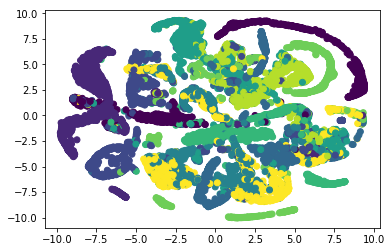

In [9]:
import matplotlib.pyplot as plt

def visualize(features, labels):
    plt.scatter(features[:,0],features[:,1],c=labels)
    plt.show()

visualize(X_val_2d, y1_val)